In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import to_networkx, to_undirected
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

In [2]:
class GCN_Net(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes):
        super(GCN_Net, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        out = F.log_softmax(x, 1)
        return x, out

In [3]:
class SAGE_Net(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes):
        super(SAGE_Net, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        out = F.log_softmax(x, 1)
        return x, out

In [4]:
def load_data(source_path, node_attr):
    with open(source_path, "r") as f:
        s_ls, d_ls = [], []
        for line in f:
            s, d = line.split(",")
            s_ls.append(int(s))
            d_ls.append(int(d))
    edge_index = torch.tensor([s_ls, d_ls], dtype=torch.long)
    undirected_edge_index = to_undirected(edge_index)
    data = Data(x=node_attr, edge_index=undirected_edge_index)
    return data

In [5]:
def plot_network(data, node_labels=None):
    fig, ax = plt.subplots()
    fig.set_tight_layout(False)
    nx_g = to_networkx(data=data).to_undirected()
    pos = nx.kamada_kawai_layout(nx_g)
    if node_labels != None:
        node_color = [[0.5, 0.5, 0.5] if x else [1, 0.5, 0.5] for x in node_labels]
    else:
        node_color = [[0.5, 0.5, 0.5]]
    nx.draw(nx_g, pos, with_labels=True, node_color=node_color)
    plt.show()

## Prepare data and plot the original network

<IPython.core.display.Javascript object>


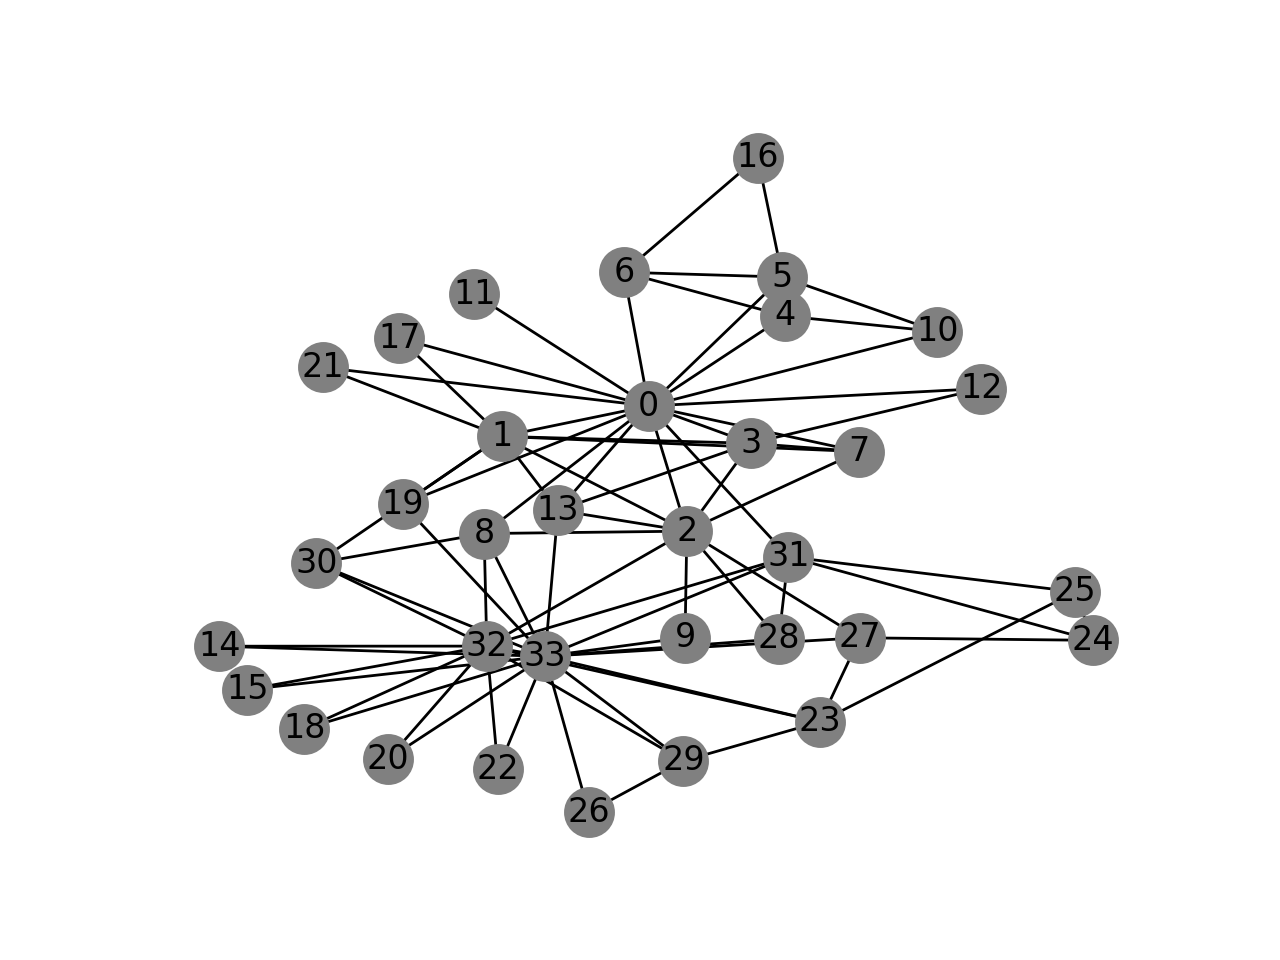

In [6]:
x = torch.eye(34)
data = load_data("links", x)
# only mark the 0 and 33 nodes
plot_network(data)

# Use GCN layer

## Train

In [8]:
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

all_logits = []
model_gcn = GCN_Net(34, 16, 2)
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=5e-4)
model_gcn.train()
for epoch in range(20):
    optimizer.zero_grad()
    logits, out = model_gcn(data)
    all_logits.append(logits.detach())
    loss = F.nll_loss(out[labeled_nodes], labels)
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6970
Epoch 1 | Loss: 0.6697
Epoch 2 | Loss: 0.6440
Epoch 3 | Loss: 0.6188
Epoch 4 | Loss: 0.5927
Epoch 5 | Loss: 0.5659
Epoch 6 | Loss: 0.5376
Epoch 7 | Loss: 0.5084
Epoch 8 | Loss: 0.4776
Epoch 9 | Loss: 0.4466
Epoch 10 | Loss: 0.4150
Epoch 11 | Loss: 0.3829
Epoch 12 | Loss: 0.3504
Epoch 13 | Loss: 0.3182
Epoch 14 | Loss: 0.2868
Epoch 15 | Loss: 0.2562
Epoch 16 | Loss: 0.2274
Epoch 17 | Loss: 0.2001
Epoch 18 | Loss: 0.1750
Epoch 19 | Loss: 0.1522


## Plot the training process

<IPython.core.display.Javascript object>


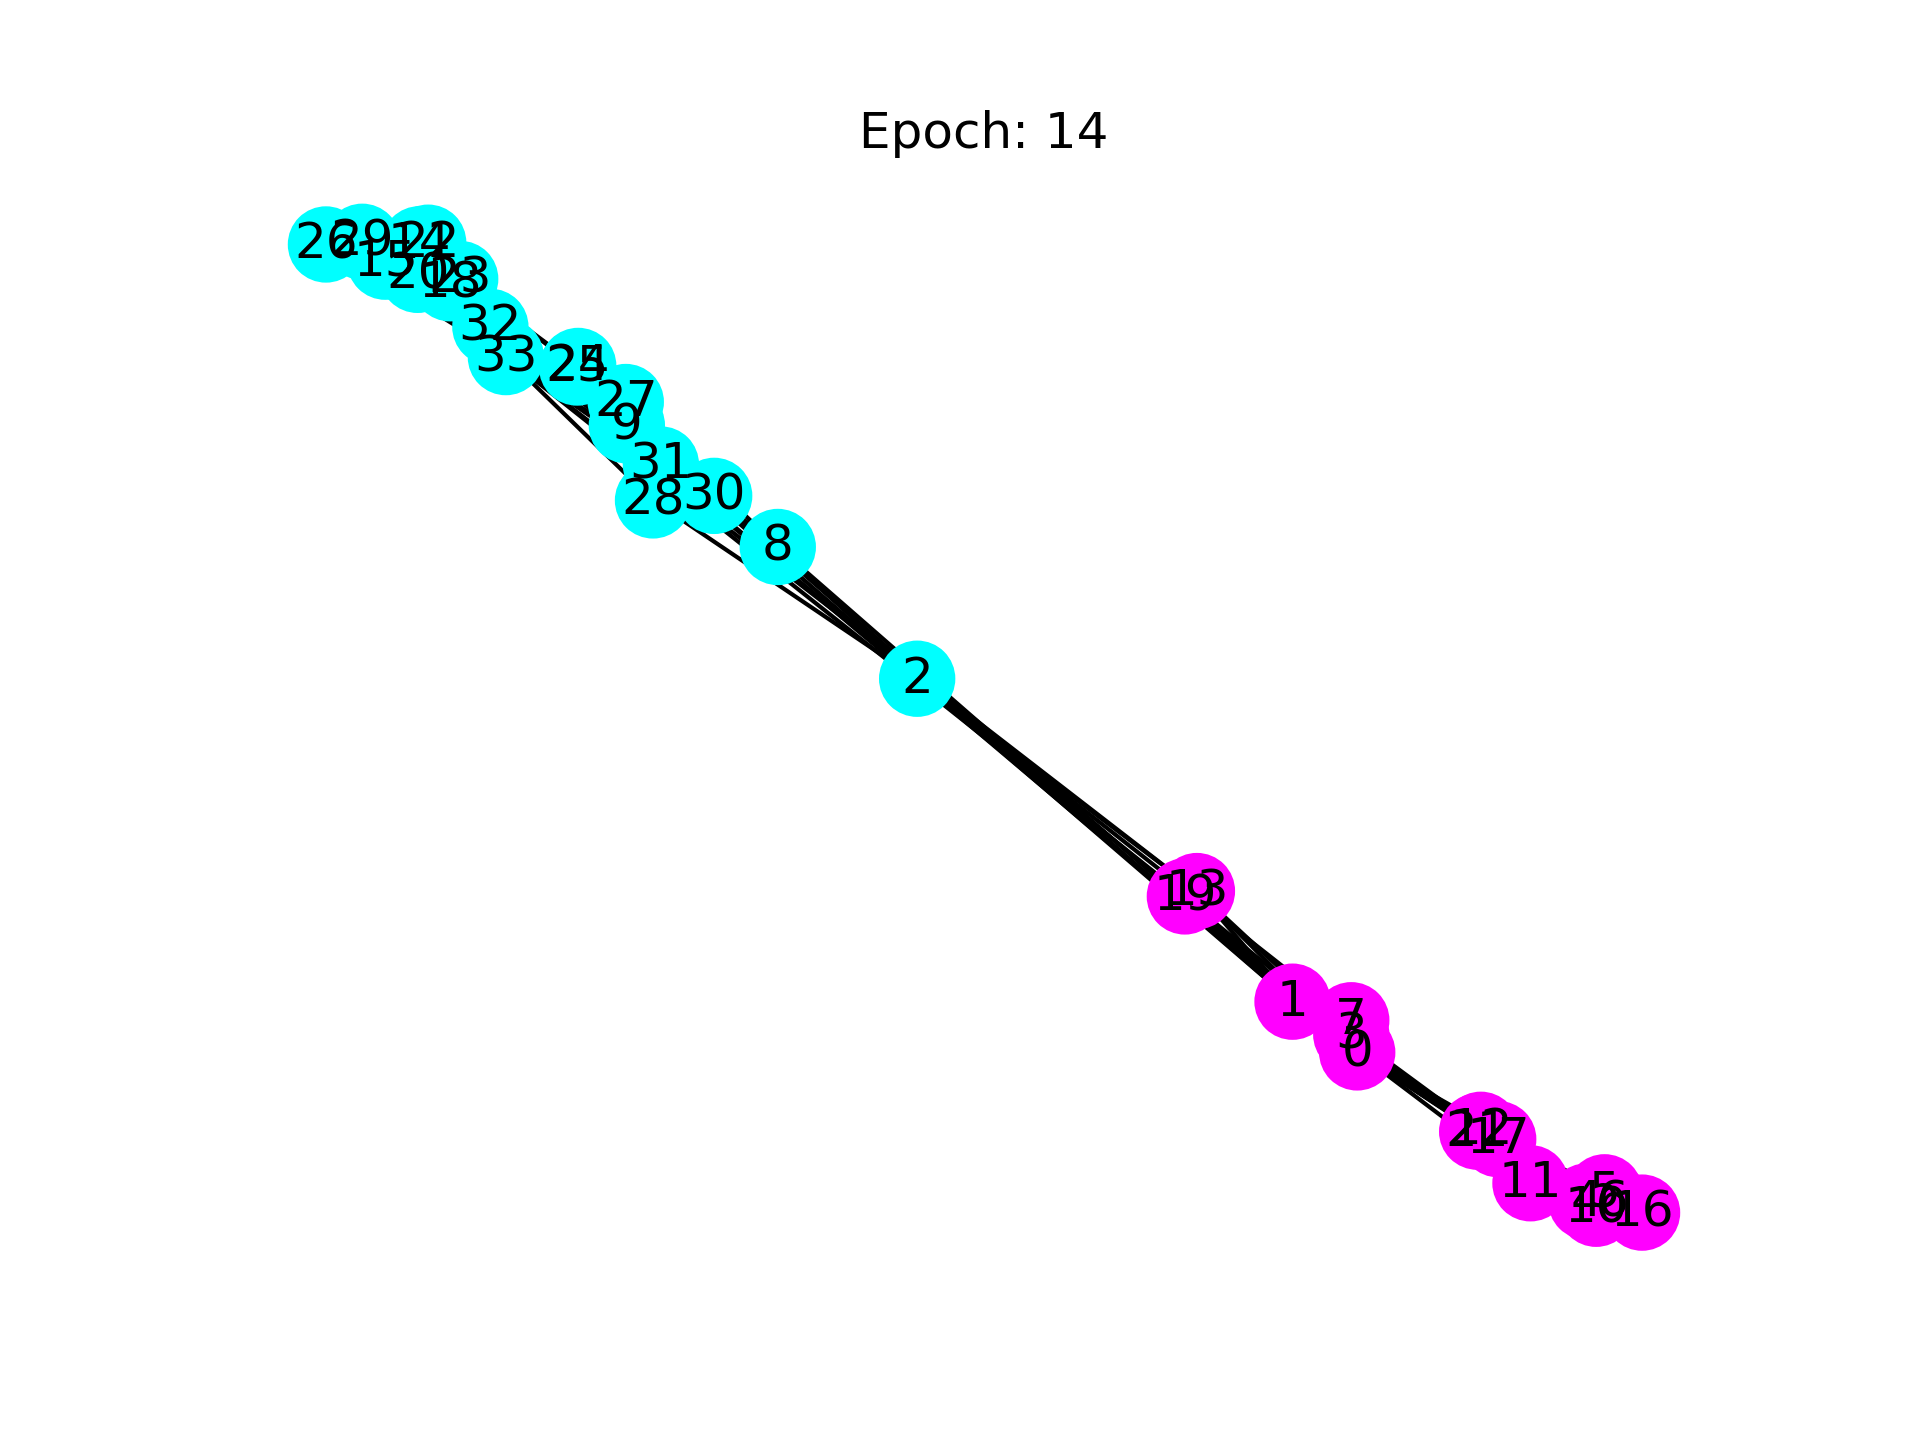

In [11]:
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_g.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)
    
nx_g = to_networkx(data=data).to_undirected()
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
plt.show()

## Plot the network with prediction GCN model

<IPython.core.display.Javascript object>


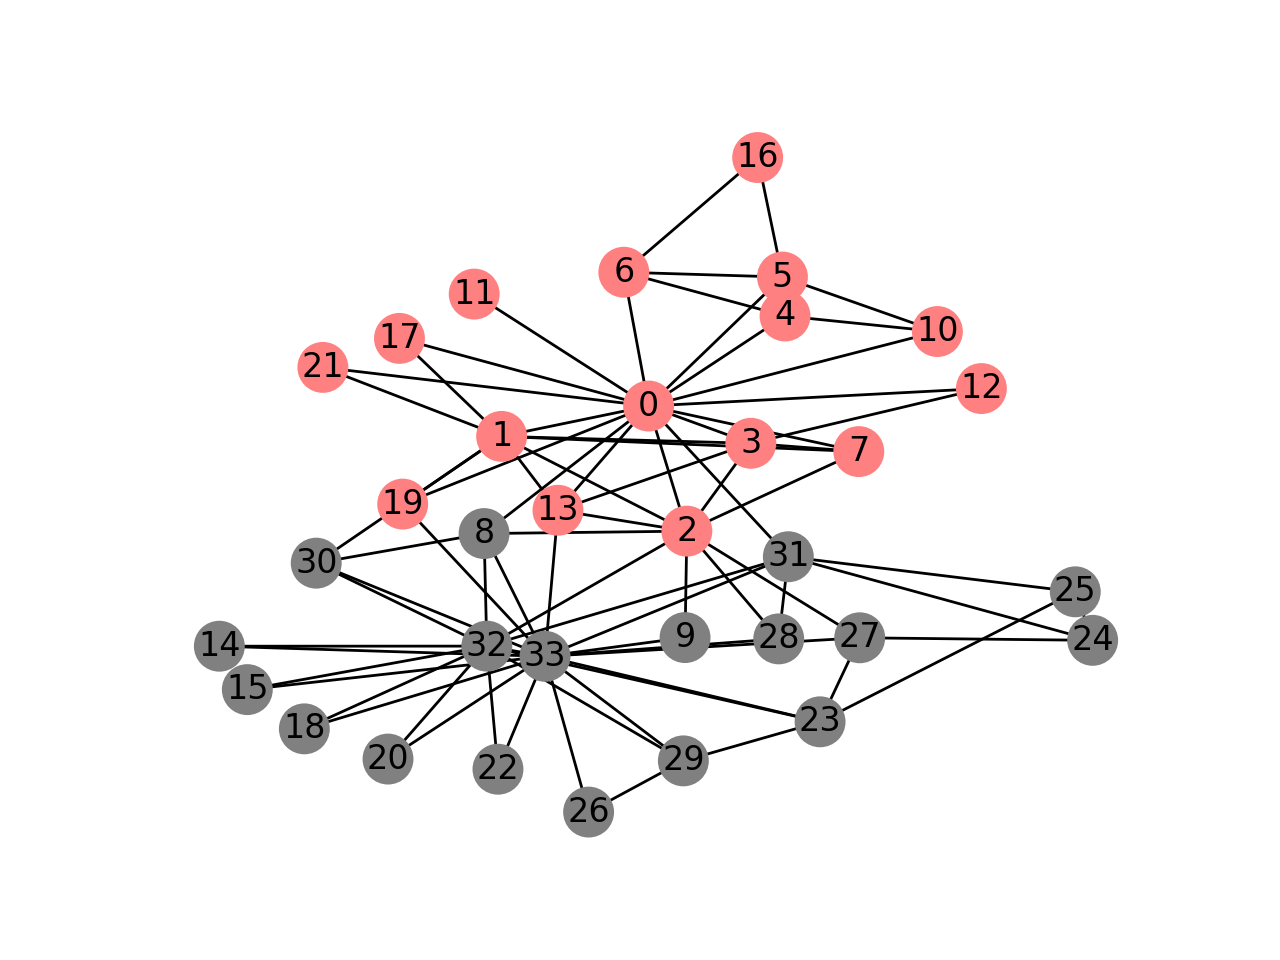

In [12]:
model_gcn.eval()
embedding_gcn, out_gcn = model_gcn(data)
pred_gcn = out.argmax(1)
plot_network(data, pred_gcn)

#  Use SAGE Convolutional layer

## Train

In [13]:
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

all_logits = []
model_sage = SAGE_Net(34, 16, 2)
optimizer = torch.optim.Adam(model_sage.parameters(), lr=0.01, weight_decay=5e-4)
model_sage.train()
for epoch in range(20):
    optimizer.zero_grad()
    logits, out = model_sage(data)
    all_logits.append(logits.detach())
    loss = F.nll_loss(out[labeled_nodes], labels)
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6945
Epoch 1 | Loss: 0.6886
Epoch 2 | Loss: 0.6828
Epoch 3 | Loss: 0.6767
Epoch 4 | Loss: 0.6703
Epoch 5 | Loss: 0.6633
Epoch 6 | Loss: 0.6557
Epoch 7 | Loss: 0.6472
Epoch 8 | Loss: 0.6379
Epoch 9 | Loss: 0.6276
Epoch 10 | Loss: 0.6165
Epoch 11 | Loss: 0.6044
Epoch 12 | Loss: 0.5915
Epoch 13 | Loss: 0.5775
Epoch 14 | Loss: 0.5625
Epoch 15 | Loss: 0.5465
Epoch 16 | Loss: 0.5295
Epoch 17 | Loss: 0.5116
Epoch 18 | Loss: 0.4928
Epoch 19 | Loss: 0.4732


## Plot the training process

<IPython.core.display.Javascript object>


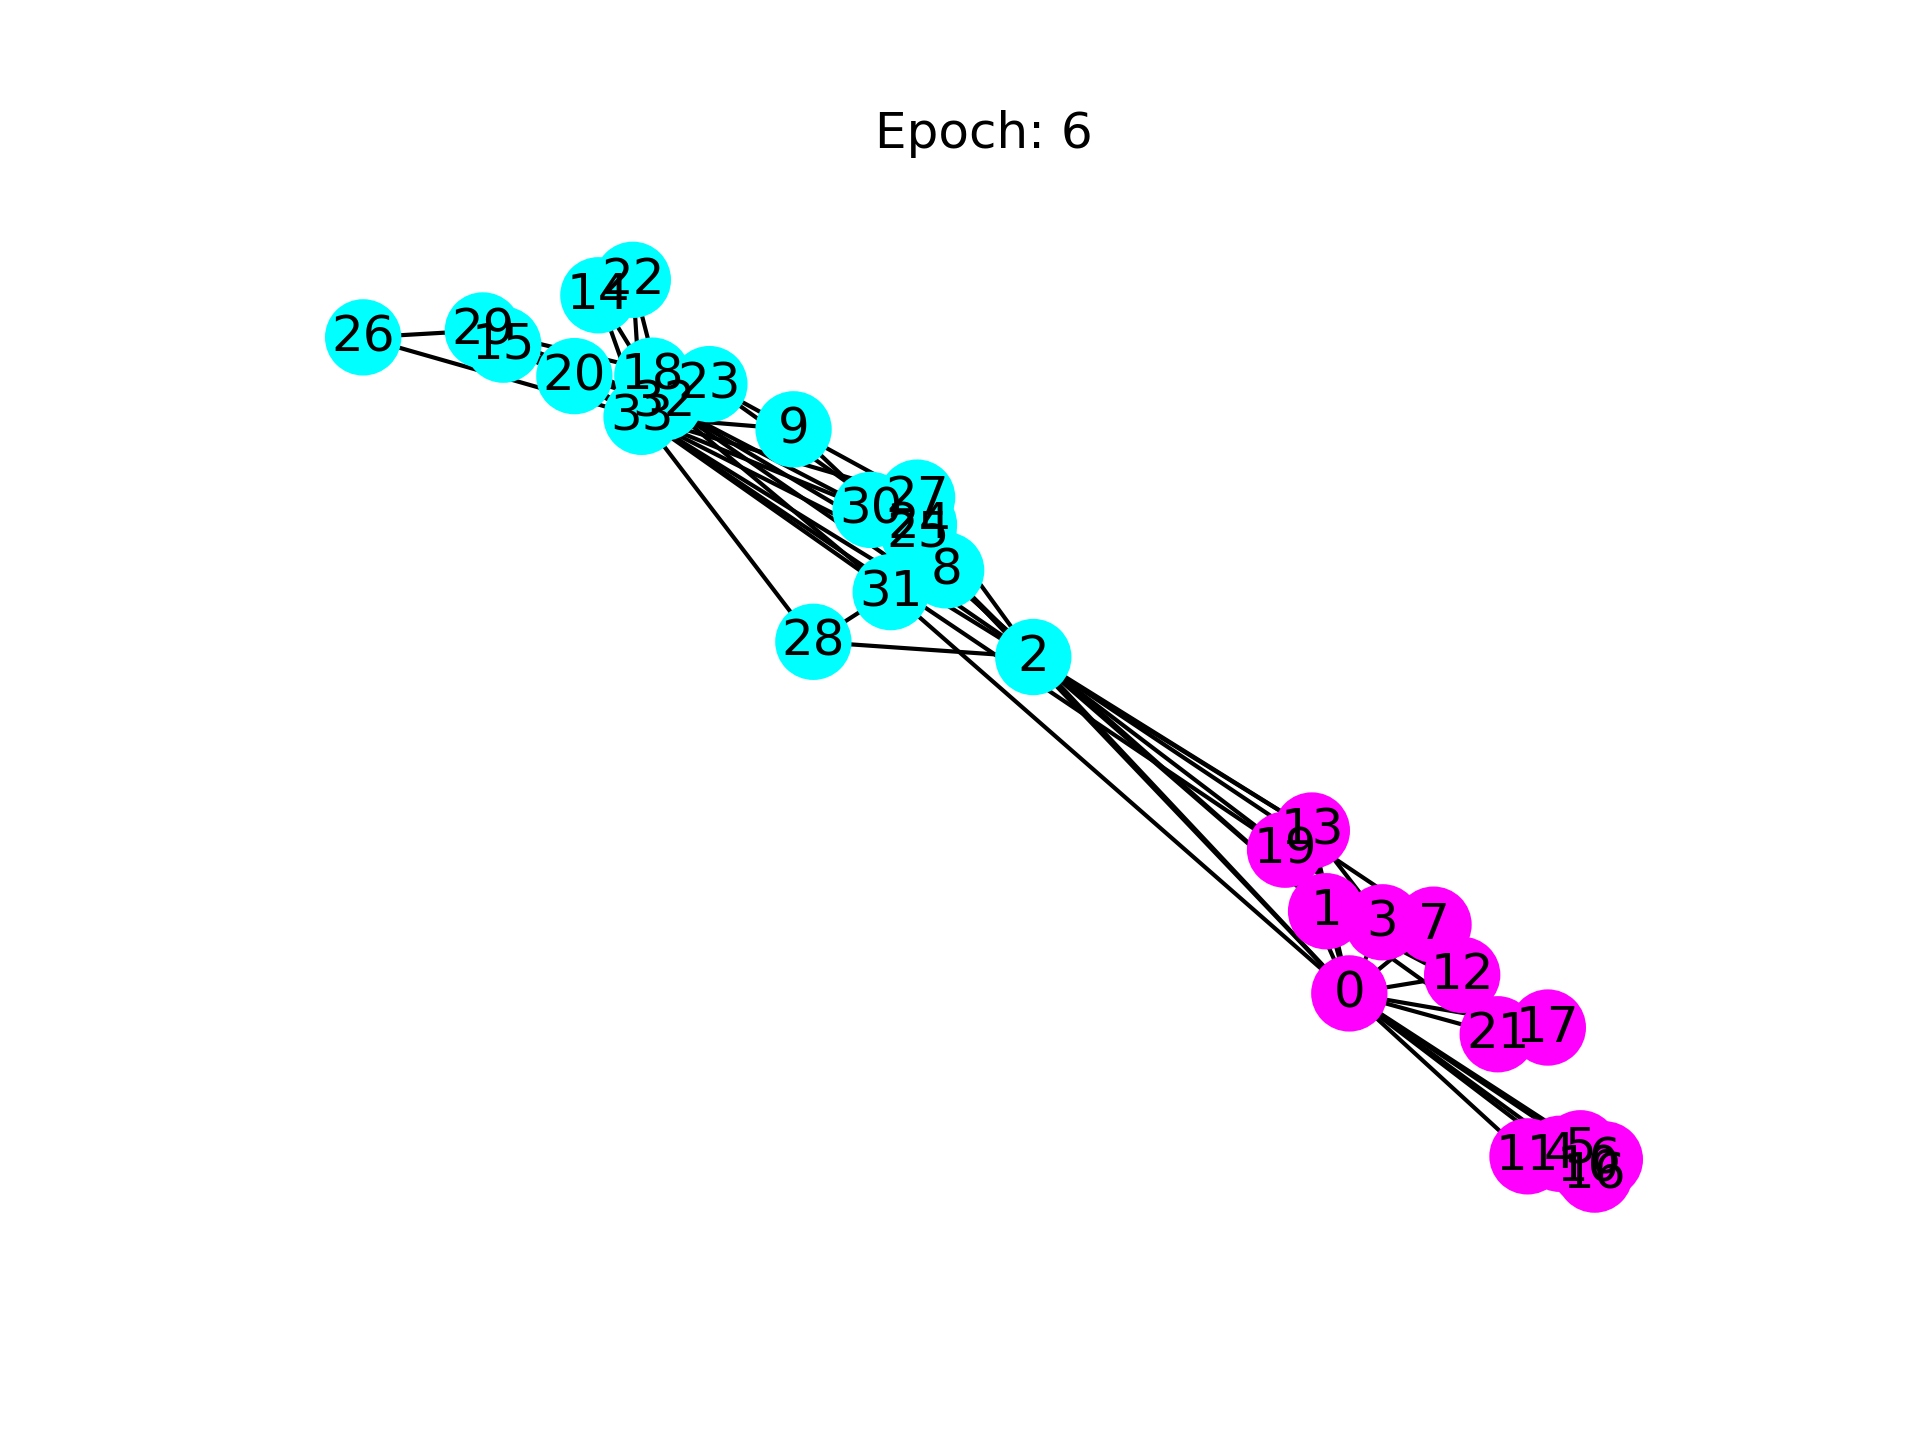

In [14]:
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_g.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)
    
nx_g = to_networkx(data=data).to_undirected()
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
plt.show()

## Plot the network with prediction by model

<IPython.core.display.Javascript object>


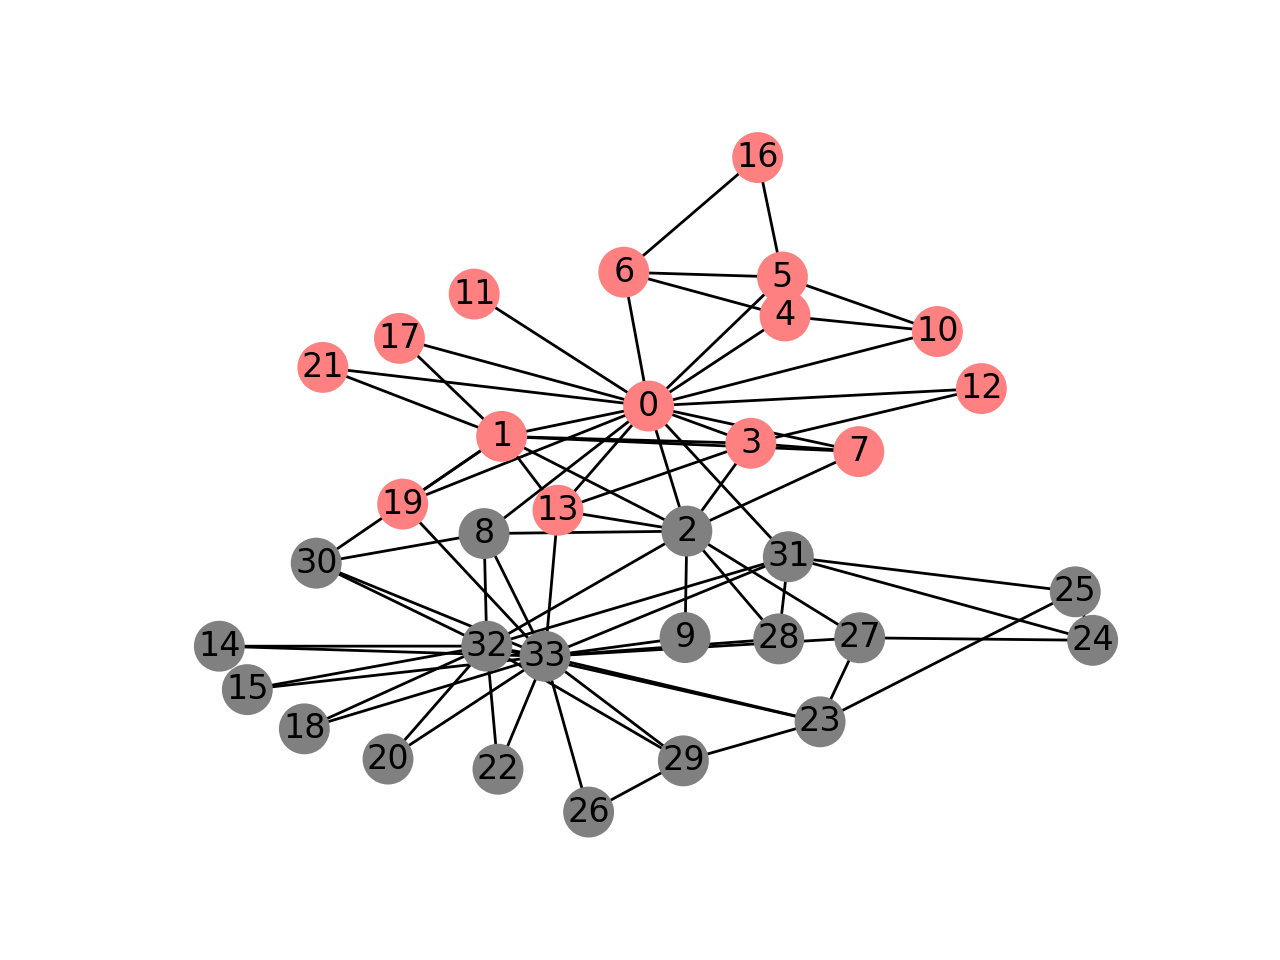

In [15]:
model_sage.eval()
embedding_sage, out_sage = model_sage(data)
pred_sage = out.argmax(1)
plot_network(data, pred_sage)